In [1]:
import pnadc #to install, run pip install git+https://github.com/AlanGanem/pnadc
from tqdm import tqdm
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

%matplotlib inline

In [2]:
paths_2020 = [*Path('../data/').glob('*2020.csv')]

In [3]:
#download if needed
if not paths_2020:
    pnadc.get_all([2020], path = 'pnadpy/', protocol = 'https')
    paths_2020 = [*Path('../data/').glob('*2020.csv')]

In [4]:
def convert_int(df, dtype = int, nan_fill = -1, valid_range = (0,100)):
    '''
    checks the columns that are composed of only integers, if so, cast to dtype (defaults to int, but could be also str or float)
    '''
    if df.__class__ == dd.DataFrame:
        return df.map_partitions(convert_int)
    
    for col in df.columns:
        if (df[col].dropna() == df[col].dropna().values.astype(int)).all():
            if not valid_range is None:
                if all(df[col].between(*valid_range)):
                    df[col] = df[col].fillna(nan_fill).astype(dtype)
                    
                    if dtype in ['str',str]:
                        df[col] = df[col].str.replace('.0', '')
            else:
                df[col] = df[col].fillna(nan_fill).astype(dtype)
                if dtype in ['str',str]:
                    df[col] = df[col].str.replace('.0', '')
            
            
                                                       
    return df

def rename_variables_pnadc(df, pnadc_dictionary_path):    
    return

def load_pnadc_dict_dataframe(dict_path_excel = r'..\data\dicionario_PNADC_microdados_trimestral.xls'):
    dic = pd.read_excel(dict_path_excel)
    dic = dic.fillna(method = 'ffill').set_index(['Código da variável'])
    return dic 

def load_cnae_codes(cnaes_path = r'..\data\Estrutura_Atividade_CNAE_Domiciliar_2_0.xls'):
    cnaes = pd.read_excel(cnaes_path)
    cnaes = cnaes.fillna(method = 'ffill')
    
    def _custom_dedup(df):
        d = {}
        d['Divisão'] = df['Divisão'].iloc[0]
        d['Seção'] = df['Seção'].iloc[0]
        d['Denominação'] = df['Denominação'].values.tolist()
        return pd.Series(d)
    
    cnaes = cnaes.groupby('Classe').apply(_custom_dedup).reset_index()   
    cnaes = cnaes.rename(
        columns = {
            'Seção':'V4013-Sec',
            'Divisão' : 'V4013-Div',
            'Classe' : 'V4013',
            'Denominação':'V4013-Name'             
        }
    )
    

    return cnaes

def create_parquet_pnadc(path, saving_path = 'PNADC/pnadc_compiled.parquet'):
    with ProgressBar():
        data = dd.read_csv(path)
        data = data.repartition('100MB').drop_duplicates()
        data.to_parquet(saving_path)
    return saving_path

# Load Data and vars dict

In [5]:
var_dict = load_pnadc_dict_dataframe()

In [6]:
var_dict.loc['UF']

,Posição inicial,Tamanho,quesito nº,Quesito Descrição,Categorias Tipo,Categorias Descrição,Período,Parte
Código da variável,,,,,,,,
UF,6.0,2.0,NaN,Unidade da Federação,11,Rondônia,1º tri/2012 - atual,Parte 1 - Identificação e Controle
UF,6.0,2.0,NaN,Unidade da Federação,12,Acre,1º tri/2012 - atual,Parte 1 - Identificação e Controle
UF,6.0,2.0,NaN,Unidade da Federação,13,Amazonas,1º tri/2012 - atual,Parte 1 - Identificação e Controle
UF,6.0,2.0,NaN,Unidade da Federação,14,Roraima,1º tri/2012 - atual,Parte 1 - Identificação e Controle
UF,6.0,2.0,NaN,Unidade da Federação,15,Pará,1º tri/2012 - atual,Parte 1 - Identificação e Controle
UF,6.0,2.0,NaN,Unidade da Federação,16,Amapá,1º tri/2012 - atual,Parte 1 - Identificação e Controle
UF,6.0,2.0,NaN,Unidade da Federação,17,Tocantins,1º tri/2012 - atual,Parte 1 - Identificação e Controle
UF,6.0,2.0,NaN,Unidade da Federação,21,Maranhão,1º tri/2012 - atual,Parte 1 - Identificação e Controle
UF,6.0,2.0,NaN,Unidade da Federação,22,Piauí,1º tri/2012 - atual,Parte 1 - Identificação e Controle


In [7]:
#create_parquet_pnadc(path = 'PNADC/*.csv')
data = dd.read_csv(paths_2020)
#filters
#ref https://rpubs.com/nataliarspires/Tutorial_PNADC_23SINAPE
data = data.query('V2009 >= 14 and VD4015 == 1') #maiores de 14 anos e trabalho remunerado

In [8]:
data = data.compute() #compute filtered data

In [9]:
data.shape[0]

592844

In [10]:
#data = data.astype(str)
#data = convert_int(data, dtype = str)


In [11]:
#var_dict.loc[rendimentos_cols]

In [12]:
var_dict.query('`Categorias Descrição` == "R$"')

,Posição inicial,Tamanho,quesito nº,Quesito Descrição,Categorias Tipo,Categorias Descrição,Período,Parte
Código da variável,,,,,,,,
V403312,188.0,8.0,33,Qual era o rendimento bruto/retirada mensal qu...,valor em reais,R$,1º tri/2012 - atual,2 - Pessoas Ocupadas
V403322,198.0,8.0,33,Qual era o rendimento bruto/retirada mensal qu...,valor em reais,R$,1º tri/2012 - atual,2 - Pessoas Ocupadas
V403412,211.0,8.0,34,Qual foi o rendimento bruto/retirada que ... r...,valor em reais,R$,1º tri/2012 - atual,2 - Pessoas Ocupadas
V403422,221.0,8.0,34,Qual foi o rendimento bruto/retirada que ... r...,valor em reais,R$,1º tri/2012 - atual,2 - Pessoas Ocupadas
V405012,261.0,8.0,50,Valor em dinheiro do rendimento mensal que rec...,valor em reais,R$,1º tri/2012 - atual,2 - Pessoas Ocupadas
V405022,271.0,8.0,50,Valor estimado dos produtos e mercadorias que ...,valor em reais,R$,1º tri/2012 - atual,2 - Pessoas Ocupadas
V405112,284.0,8.0,51,Valor em dinheiro do rendimento mensal que rec...,valor em reais,R$,1º tri/2012 - atual,2 - Pessoas Ocupadas
V405122,294.0,8.0,51,Valor estimado dos produtos e mercadorias que ...,valor em reais,R$,1º tri/2012 - atual,2 - Pessoas Ocupadas
V405812,312.0,8.0,58,Valor em dinheiro do rendimento mensal que rec...,valor em reais,R$,1º tri/2012 - atual,2 - Pessoas Ocupadas


In [13]:
rendimentos_cols = [
    'VD4016' 
]

In [14]:
rendimentos = data[rendimentos_cols]

In [15]:
(rendimentos == 0).mean()

VD4016    0.0
dtype: float64

C:\Users\User Ambev\Desktop\Mestrado\MO444\MO444env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

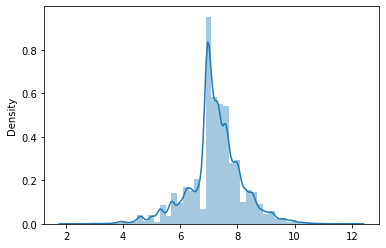

In [16]:
sns.distplot(np.log(rendimentos[rendimentos > 0].sample(frac = 0.1)))

In [17]:
var_dict.loc['V2010']

,Posição inicial,Tamanho,quesito nº,Quesito Descrição,Categorias Tipo,Categorias Descrição,Período,Parte
Código da variável,,,,,,,,
V2010,95.0,1.0,10,Cor ou raça,1,Branca,1º tri/2012 - atual,Parte 2 - Características Gerais dos Moradores
V2010,95.0,1.0,10,Cor ou raça,2,Preta,1º tri/2012 - atual,Parte 2 - Características Gerais dos Moradores
V2010,95.0,1.0,10,Cor ou raça,3,Amarela,1º tri/2012 - atual,Parte 2 - Características Gerais dos Moradores
V2010,95.0,1.0,10,Cor ou raça,4,Parda,1º tri/2012 - atual,Parte 2 - Características Gerais dos Moradores
V2010,95.0,1.0,10,Cor ou raça,5,Indígena,1º tri/2012 - atual,Parte 2 - Características Gerais dos Moradores
V2010,95.0,1.0,10,Cor ou raça,9,Ignorado,1º tri/2012 - atual,Parte 2 - Características Gerais dos Moradores


In [18]:
raca = data['V2010']

raca.value_counts(1)

4.0    0.476840
1.0    0.424537
2.0    0.089572
3.0    0.005118
5.0    0.003760
9.0    0.000174
Name: V2010, dtype: float64

In [19]:
raca_binary = data['V2010']
sex = data['V2007']

In [20]:
sex.loc[sex == 1] = 'Masculino'
sex.loc[sex == 2] = 'Feminino'

In [21]:
raca_binary.loc[raca_binary.isin([9])] = 'Ignorado'
raca_binary.loc[raca_binary.isin([1,3])] = 'Branca ou Amarela'
raca_binary.loc[raca_binary.isin([2,4,5])] = 'Preta, Parda ou Indígena'

C:\Users\User Ambev\Desktop\Mestrado\MO444\MO444env\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [22]:
pd.concat([raca_binary,rendimentos, sex], axis = 1).groupby(['V2007','V2010'])['VD4016'].describe()

count         mean           std  \
V2007     V2010                                                           
Feminino  Branca ou Amarela         110010.0  2434.984347   3191.328347   
          Ignorado                      44.0  1851.136364   1553.666655   
          Preta, Parda ou Indígena  133719.0  1495.233953   1776.013659   
Masculino Branca ou Amarela         144708.0  3089.524352   4748.443123   
          Ignorado                      59.0  5734.915254  13741.702998   
          Preta, Parda ou Indígena  204304.0  1783.314262   2312.968669   

                                      min     25%     50%     75%       max  
V2007     V2010                                                              
Feminino  Branca ou Amarela           8.0  1045.0  1500.0  2665.5  100000.0  
          Ignorado                  150.0   800.0  1237.5  2275.0    6500.0  
          Preta, Parda ou Indígena   10.0   700.0  1045.0  1600.0  100000.0  
Masculino Branca ou Amarela          10.0  1100.0  1885.0  3000.0  250000.0  
          Ignorado                  400.0  1045.0  1500.0  3000.0   60000.0  
          Preta, Parda ou Indígena    4.0   900.0  1200.0  2000.0  100000.0

# Feature engineering

In [23]:
data['V2010-Bin'] = raca_binary
data['V2007-Bin'] = sex

data['V4010-SubP'] = data['V4010'].astype(str).str[:2] #subgrupo principal of ocupation according to Estrutura_Ocupacao_COD
data['VD4016-Log'] = np.log(data['VD4016']) #wage log

data = data.merge(load_cnae_codes()[['V4013', 'V4013-Sec']], how = 'left', on = 'V4013') ## CNAE-Section of sector of the job

In [24]:
#filter out rows where race is empty
data = data[data['V2010-Bin'] != 'Ignorado']

# Find Confounders

Confounders are good predictors of both the treatment and the observed outcome.
Knowing what are these variables are usefull because in order to remove bias we have to control for confounders

In [25]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score, r2_score

In [26]:
def PredictionTransformerWrapper(estimator, transform_method = 'apply'):
    '''
    factory to allow specific methods to be exposed as a transform method,
    allowing its usage in sklearn pipelines
    '''
    class PredictionTransformer(estimator):        
        def transform(self, X, **kwargs):
            return getattr(self, transform_method)(X, **kwargs)

class RobustEncoder(BaseEstimator, TransformerMixin):

    def __init__(self,):
        '''
        A robust one hot encoder. Always return the same amount of nonzero value sin each transformed row.
        Has columns for unknown values
        '''
        return

    def fit(self, X, y = None, **kwawrgs):
        X = np.array(X)
        X = X.astype(str)
        
        self.ordinalencoder_ = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1).fit(X)
        X = self.ordinalencoder_.transform(X)
        
        categories = [np.arange(-1, len(cats)) for cats in self.ordinalencoder_.categories_]        
        self.onehotencoder_ = OneHotEncoder(categories = categories).fit(X)
        return self

    def transform(self, X, **kwargs):
        X = np.array(X)
        X = X.astype(str)
        X = self.ordinalencoder_.transform(X)
        return self.onehotencoder_.transform(X)
    
def make_numerical_and_categorical_pipeline(categorical_columns, numerical_columns, final_estimator = None):
    
    pipe = ColumnTransformer(
        [
            ('OneHotEncoder', RobustEncoder(), categorical_columns),
            ('NumericalPassthrough', FunctionTransformer(lambda x: x.astype(float)), numerical_columns),            
        ]
    )
    
    if not final_estimator is None:
        pipe = Pipeline(
            [
                ('PreprocessingPipeline', pipe),
                ('FinalEstimator', final_estimator)
            ]
        )
        
    return pipe

## Feature Importances

### First run

In [27]:
categorical_columns = [
    'UF', #estado
    'V1022', #zona rural ou urbana
    'V1023', # região do estado    
    'V3001', #sabe ler ou escrever?
    'V4010-SubP', #subgrupo principal da ocupação de acordo com Estrutura_Ocupacao_COD
    'V4012', #Nesse trabalho,... era
    'V4013-Sec', #seção do código CNAE da principal atividade do trabalho
    'V4014', #esfera do trabalho (Federal estadual ou municipal)
    'VD3004', #nível de instrução mais elevado alcançado
    'V3009A', #curso mais alto que frequentou anteriormente
    #'VD4013', #Faixa das horas habitualmente trabalhadas
    #'VD4032', #Horas efetivamente trabalhadas na semana de referência no trabalho principal para pessoas de 14 anos ou mais de idade    
]

numerical_columns = [
    'V2009', #idade
    'VD3005', #anos de estudo
]

treatment_columns = [
    'V2007-Bin', #sexo
    'V2010-Bin', #cor ou raça binária (branco ou amarelo/ preto pardo ou indigena)
]

target_columns = [
    'VD4016-Log', #Rendimento mensal habitual logaritmico do trabalho principal para pessoas de 14 anos ou mais de idade (apenas para pessoas que receberam em dinheiro, produtos ou mercadorias no trabalho principal)
]

X_columns = categorical_columns + numerical_columns
T_columns = treatment_columns
y_columns = target_columns


In [28]:
train_frac = 0.8
train_idxs = np.random.choice(range(len(data)), size = int(len(data)*train_frac), replace = False)

train_msk = np.empty((len(data),), dtype = bool)
train_msk[:] = False
train_msk[train_idxs] = True
test_msk = ~train_msk

In [29]:
#estim = RandomForestRegressor(20, criterion = 'absolute_error', min_samples_leaf = 20, oob_score = True, n_jobs = -1, verbose = 1)
estim = RandomForestClassifier(50, criterion = 'gini', min_samples_leaf = 20, oob_score = True, n_jobs = -1, verbose = 1)
#estim = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.1, n_jobs = -1, verbose = 1)
pipe_treatment = make_numerical_and_categorical_pipeline(categorical_columns, numerical_columns,estim)

In [30]:
pipe_treatment.fit(data[X_columns][train_msk], data[T_columns[0]][train_msk])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.3min finished


Pipeline(steps=[('PreprocessingPipeline',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  RobustEncoder(),
                                                  ['UF', 'V1022', 'V1023',
                                                   'V3001', 'V4010-SubP',
                                                   'V4012', 'V4013-Sec',
                                                   'V4014', 'VD3004',
                                                   'V3009A']),
                                                 ('NumericalPassthrough',
                                                  FunctionTransformer(func=<function make_numerical_and_categorical_pipeline.<locals>.<lambda> at 0x0000026492132B80>),
                                                  ['V2009', 'VD3005'])])),
                ('FinalEstimator',
                 RandomForestClassifier(min_samples_leaf=20, n_estimators=50,
                                       

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.3s finished


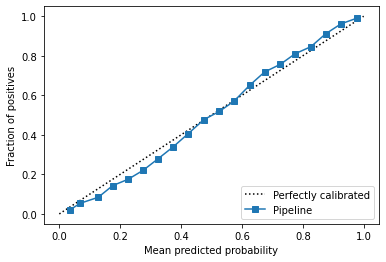

In [31]:
from sklearn.calibration import CalibrationDisplay
display = CalibrationDisplay.from_estimator(
    pipe_treatment,
    data[X_columns][test_msk],
    data[T_columns[0]][test_msk],
    n_bins=20,
)

In [32]:
def auc_scoring(estim, X, y):
    return roc_auc_score(OneHotEncoder(sparse = False).fit_transform(y), estim.predict_proba(X), multi_class = 'ovr')

importances = permutation_importance(pipe_treatment, data[X_columns][test_msk], data[[T_columns[0]]][test_msk], n_repeats = 10, n_jobs = -1, scoring = auc_scoring)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.3s finished


In [33]:
auc_scoring(pipe_treatment, data[X_columns][test_msk], data[[T_columns[0]]][test_msk])

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.3s finished


0.8728112205682468

<AxesSubplot:xlabel='value', ylabel='feature'>

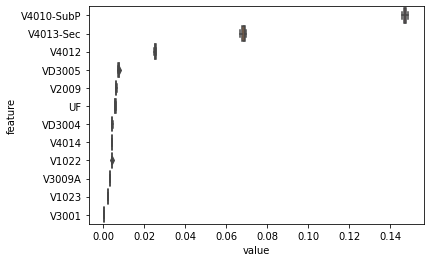

In [34]:
importances_df = pd.DataFrame(importances['importances'])
importances_df['feature'] = X_columns
importances_df = importances_df.melt(id_vars = ['feature'], var_name = 'iter')
rank = importances_df.groupby('feature')['value'].sum().sort_values(ascending = False)

#importances_df.groupby('feature').apply(lambda x: sns.boxplot(y = x['importances'], x = x['rank']))
sns.boxplot(x="value", 
            y="feature",
            data=importances_df,
            order = rank.index 
           )
#plt.legend()

Podemos ver que existe uma associação forte entre variáveis referentes ao tipo de trabalho e o recorte racial.
Isso pode ser um problema, no sentido em que essas variáveis são [mediadores](https://en.wikipedia.org/wiki/Mediation_(statistics)#Direct_versus_indirect_effects). Por exemplo: o racismo estrutural faz com que pessoas de mesma qualificação não consiga cargos gerenciais e de liderança, ou empregos npor exemplo etc.

Por isso, serão omitidas as variáveis referentes à natureza da ocupação (Exceto a parte que diz respeito o setor do trabalho pelo CNAE), para evitar viés de seleção através do controle de mediadores ('V4010', 'V4013', 'V4012', 'V4014').

é interessante porque isso já antecipa o viés que pode ser encontrado quando for feita a regressão do salário utilizando as mesmas variáveis

### Second run

In [119]:
categorical_columns = [
    'UF', #estado
    'V1022', #zona rural ou urbana
    'V1023', # região do estado    
    'V3001', #sabe ler ou escrever?
    
    #'V4010-SubP', #subgrupo principal da ocupação de acordo com Estrutura_Ocupacao_COD
    #'V4012', #Nesse trabalho,... era
    'V4013-Sec', #seção do código CNAE da principal atividade do trabalho
    'V4014', #esfera do trabalho (Federal estadual ou municipal)
    #'VD4013', #Faixa das horas habitualmente trabalhadas
    #'VD4032', #Horas efetivamente trabalhadas na semana de referência no trabalho principal para pessoas de 14 anos ou mais de idade    
    
    
    'V3009A', #curso mais alto que frequentou anteriormente
    'VD3004', #nível de instrução mais elevado alcançado
    
]

numerical_columns = [
    'V2009', #idade
    'VD3005', #anos de estudo
]

treatment_columns = [
    'V2007-Bin', #sexo
    'V2010-Bin', #cor ou raça binária (branco ou amarelo/ preto pardo ou indigena)
]

target_columns = [
    'VD4016-Log', #Rendimento mensal habitual do trabalho principal para pessoas de 14 anos ou mais de idade (apenas para pessoas que receberam em dinheiro, produtos ou mercadorias no trabalho principal)
]

X_columns = categorical_columns + numerical_columns
T_columns = treatment_columns
y_columns = target_columns


In [120]:
train_frac = 0.8
train_idxs = np.random.choice(range(len(data)), size = int(len(data)*train_frac), replace = False)

train_msk = np.empty((len(data),), dtype = bool)
train_msk[:] = False
train_msk[train_idxs] = True
test_msk = ~train_msk

#### Sex Prediction

In [121]:
#estim = RandomForestRegressor(20, criterion = 'absolute_error', min_samples_leaf = 20, oob_score = True, n_jobs = -1, verbose = 1)
estim = RandomForestClassifier(50, criterion = 'gini', min_samples_leaf = 20, oob_score = True, n_jobs = -1, verbose = 1)
#estim = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.1, n_jobs = -1, verbose = 1)
pipe_sex = make_numerical_and_categorical_pipeline(categorical_columns, numerical_columns,estim)

In [122]:
pipe_sex.fit(data[X_columns][train_msk], data[T_columns[0]][train_msk])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.6min finished


Pipeline(steps=[('PreprocessingPipeline',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  RobustEncoder(),
                                                  ['UF', 'V1022', 'V1023',
                                                   'V3001', 'V4013-Sec',
                                                   'V4014', 'V3009A',
                                                   'VD3004']),
                                                 ('NumericalPassthrough',
                                                  FunctionTransformer(func=<function make_numerical_and_categorical_pipeline.<locals>.<lambda> at 0x00000264A608DC10>),
                                                  ['V2009', 'VD3005'])])),
                ('FinalEstimator',
                 RandomForestClassifier(min_samples_leaf=20, n_estimators=50,
                                        n_jobs=-1, oob_score=True,
                                        verbos

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.3s finished


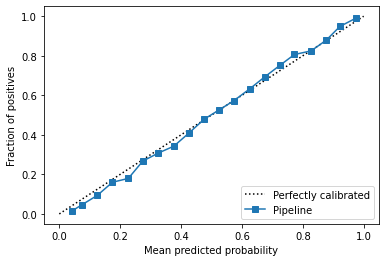

In [123]:
from sklearn.calibration import CalibrationDisplay
display = CalibrationDisplay.from_estimator(
    pipe_sex,
    data[X_columns][test_msk],
    data[T_columns[0]][test_msk],
    n_bins=20,
)

In [124]:
importances = permutation_importance(pipe_sex, data[X_columns][test_msk], data[[T_columns[0]]][test_msk], n_repeats = 10, n_jobs = -1, scoring = auc_scoring)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.5s finished


In [125]:
auc_scoring(pipe_sex, data[X_columns][test_msk], data[[T_columns[0]]][test_msk])

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.3s finished


0.8101111991884

<AxesSubplot:xlabel='value', ylabel='feature'>

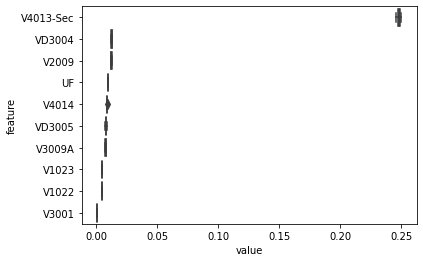

In [126]:
importances_df = pd.DataFrame(importances['importances'])
importances_df['feature'] = X_columns
importances_df = importances_df.melt(id_vars = ['feature'], var_name = 'iter')
rank = importances_df.groupby('feature')['value'].sum().sort_values(ascending = False)

#importances_df.groupby('feature').apply(lambda x: sns.boxplot(y = x['importances'], x = x['rank']))
sns.boxplot(x="value", 
            y="feature",
            data=importances_df,
            order = rank.index 
           )
#plt.legend()

In [43]:
var_dict.loc[rank.index].reset_index().drop_duplicates(var_dict.index.name)

,Código da variável,Posição inicial,Tamanho,quesito nº,Quesito Descrição,Categorias Tipo,Categorias Descrição,Período,Parte
0,V2009,92.0,3.0,9,Idade do morador na data de referência,0 a 130,Idade (em anos),1º tri/2012 - atual,Parte 2 - Características Gerais dos Moradores
1,VD3004,391.0,1.0,82,Nível de instrução mais elevado alcançado (pes...,1,Sem instrução e menos de 1 ano de estudo,1º tri/2012 - atual,Variáveis Derivadas
9,UF,6.0,2.0,NaN,Unidade da Federação,11,Rondônia,1º tri/2012 - atual,Parte 1 - Identificação e Controle
36,V3009A,113.0,2.0,9A,Qual foi o curso mais elevado que ... frequent...,01,Creche (disponível apenas no questionário anua...,4º tri/2015 - atual,Parte 3 - Características de educação para os ...
52,VD3005,392.0,2.0,82,Anos de estudo (pessoas de 5 anos ou mais de i...,0,Sem instrução e menos de 1 ano de estudo,1º tri/2012 - atual,Variáveis Derivadas
70,V1022,33.0,1.0,NaN,Situação do domicílio,1,Urbana,1º tri/2012 - atual,Parte 1 - Identificação e Controle
72,V1023,34.0,1.0,NaN,Tipo de área,1,Capital,1º tri/2012 - atual,Parte 1 - Identificação e Controle
76,V3001,96.0,1.0,1,... sabe ler e escrever?,1,Sim,1º tri/2012 - atual,Parte 3 - Características de educação para os ...


Podemos ver que o efeito é mais moderado nesses potenciais confundidores.

#### Race Prediction

In [59]:
#estim = RandomForestRegressor(20, criterion = 'absolute_error', min_samples_leaf = 20, oob_score = True, n_jobs = -1, verbose = 1)
estim = RandomForestClassifier(50, criterion = 'gini', min_samples_leaf = 10, n_jobs = -1, verbose = 1)
#estim = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.1, n_jobs = -1, verbose = 1)
pipe_race = make_numerical_and_categorical_pipeline(categorical_columns, numerical_columns,estim)

In [60]:
pipe_race.fit(data[X_columns][train_msk], data[T_columns[1]][train_msk])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.2min finished


Pipeline(steps=[('PreprocessingPipeline',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  RobustEncoder(),
                                                  ['UF', 'V1022', 'V1023',
                                                   'V3001', 'V3009A',
                                                   'VD3004']),
                                                 ('NumericalPassthrough',
                                                  FunctionTransformer(func=<function make_numerical_and_categorical_pipeline.<locals>.<lambda> at 0x00000264AA7E7A60>),
                                                  ['V2009', 'VD3005'])])),
                ('FinalEstimator',
                 RandomForestClassifier(min_samples_leaf=10, n_estimators=50,
                                        n_jobs=-1, oob_score=True,
                                        verbose=1))])

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


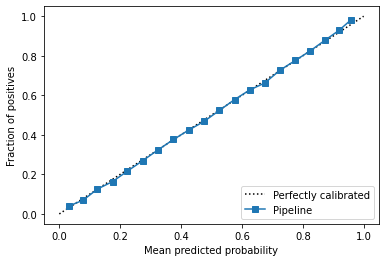

In [ ]:
from sklearn.calibration import CalibrationDisplay, calibration_curve

display = CalibrationDisplay.from_estimator(
    pipe_race,
    data[X_columns][test_msk],
    data[T_columns[1]][test_msk],
    n_bins=20,
)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished
C:\Users\User Ambev\Desktop\Mestrado\MO444\MO444env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

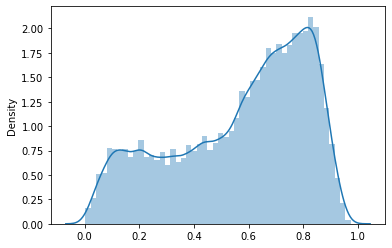

In [65]:
sns.distplot(pipe_race.predict_proba(data[X_columns][test_msk])[:,1])

In [63]:
(
    auc_scoring(pipe_race, data[X_columns][train_msk], data[[T_columns[0]]][train_msk]),
    auc_scoring(pipe_race, data[X_columns][test_msk], data[[T_columns[0]]][test_msk])
)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


(0.5464634603426093, 0.547964270363575)

In [85]:
importances = permutation_importance(pipe_race, data[X_columns][test_msk], data[[T_columns[1]]][test_msk], n_repeats = 10, n_jobs = -1, scoring = auc_scoring)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


<AxesSubplot:xlabel='value', ylabel='feature'>

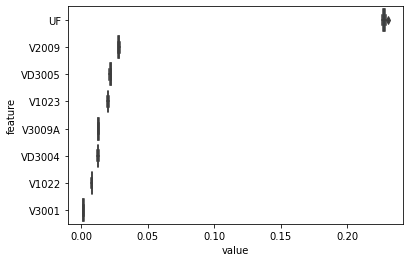

In [86]:
importances_df = pd.DataFrame(importances['importances'])
importances_df['feature'] = X_columns
importances_df = importances_df.melt(id_vars = ['feature'], var_name = 'iter')
rank = importances_df.groupby('feature')['value'].sum().sort_values(ascending = False)

#importances_df.groupby('feature').apply(lambda x: sns.boxplot(y = x['importances'], x = x['rank']))
sns.boxplot(x="value", 
            y="feature",
            data=importances_df,
            order = rank.index 
           )
#plt.legend()

In [87]:
var_dict.loc[rank.index].reset_index().drop_duplicates(var_dict.index.name)

,Código da variável,Posição inicial,Tamanho,quesito nº,Quesito Descrição,Categorias Tipo,Categorias Descrição,Período,Parte
0,UF,6.0,2.0,NaN,Unidade da Federação,11,Rondônia,1º tri/2012 - atual,Parte 1 - Identificação e Controle
27,V2009,92.0,3.0,9,Idade do morador na data de referência,0 a 130,Idade (em anos),1º tri/2012 - atual,Parte 2 - Características Gerais dos Moradores
28,VD3005,392.0,2.0,82,Anos de estudo (pessoas de 5 anos ou mais de i...,0,Sem instrução e menos de 1 ano de estudo,1º tri/2012 - atual,Variáveis Derivadas
46,V1023,34.0,1.0,NaN,Tipo de área,1,Capital,1º tri/2012 - atual,Parte 1 - Identificação e Controle
50,V3009A,113.0,2.0,9A,Qual foi o curso mais elevado que ... frequent...,01,Creche (disponível apenas no questionário anua...,4º tri/2015 - atual,Parte 3 - Características de educação para os ...
66,VD3004,391.0,1.0,82,Nível de instrução mais elevado alcançado (pes...,1,Sem instrução e menos de 1 ano de estudo,1º tri/2012 - atual,Variáveis Derivadas
74,V1022,33.0,1.0,NaN,Situação do domicílio,1,Urbana,1º tri/2012 - atual,Parte 1 - Identificação e Controle
76,V3001,96.0,1.0,1,... sabe ler e escrever?,1,Sim,1º tri/2012 - atual,Parte 3 - Características de educação para os ...


#### Wage Prediction

In [88]:
estim = RandomForestRegressor(40, criterion = 'squared_error', min_samples_leaf = 5, oob_score = True, n_jobs = -1, verbose = 1)
#estim = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.1, n_jobs = -1, verbose = 1)
pipe_wage = make_numerical_and_categorical_pipeline(categorical_columns, numerical_columns,estim)

In [89]:
pipe_wage.fit(data[X_columns][train_msk], data[y_columns][train_msk])

C:\Users\User Ambev\Desktop\Mestrado\MO444\MO444env\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  4.0min finished


Pipeline(steps=[('PreprocessingPipeline',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  RobustEncoder(),
                                                  ['UF', 'V1022', 'V1023',
                                                   'V3001', 'V3009A',
                                                   'VD3004']),
                                                 ('NumericalPassthrough',
                                                  FunctionTransformer(func=<function make_numerical_and_categorical_pipeline.<locals>.<lambda> at 0x00000264ABD1AEE0>),
                                                  ['V2009', 'VD3005'])])),
                ('FinalEstimator',
                 RandomForestRegressor(min_samples_leaf=5, n_estimators=40,
                                       n_jobs=-1, oob_score=True, verbose=1))])

In [90]:
from sklearn.calibration import CalibrationDisplay

r2_score(
    data[y_columns][test_msk],
    pipe_wage.predict(data[X_columns][test_msk]),
    sample_weight=None,
    multioutput='uniform_average'
)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished


0.4378753319637094

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.2s finished
C:\Users\User Ambev\Desktop\Mestrado\MO444\MO444env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


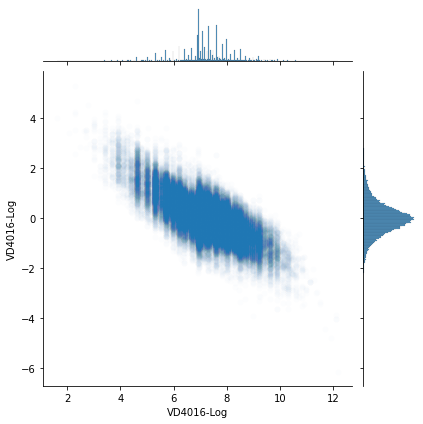

In [91]:
preds = pipe_wage.predict(data[X_columns][test_msk])

err = preds.flatten() - data[y_columns[0]][test_msk]

sns.jointplot(data[y_columns[0]][test_msk], err, joint_kws = dict(alpha = 0.01))

In [92]:
def r2_scoring(estim, X, y):
    return r2_score(
            y,
            estim.predict(X),
            sample_weight=None,
            multioutput='uniform_average'
        )

importances = permutation_importance(pipe_wage, data[X_columns][test_msk], data[y_columns][test_msk], n_repeats = 10, n_jobs = -1, scoring = r2_scoring)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.2s finished


<AxesSubplot:xlabel='value', ylabel='feature'>

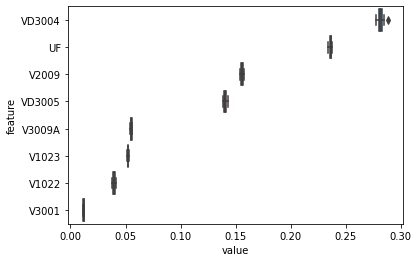

In [93]:
importances_df = pd.DataFrame(importances['importances'])
importances_df['feature'] = X_columns
importances_df = importances_df.melt(id_vars = ['feature'], var_name = 'iter')
rank = importances_df.groupby('feature')['value'].sum().sort_values(ascending = False)

#importances_df.groupby('feature').apply(lambda x: sns.boxplot(y = x['importances'], x = x['rank']))
sns.boxplot(x="value", 
            y="feature",
            data=importances_df,
            order = rank.index 
           )
#plt.legend()

In [94]:
var_dict.loc[rank.index].reset_index().drop_duplicates(var_dict.index.name)

,Código da variável,Posição inicial,Tamanho,quesito nº,Quesito Descrição,Categorias Tipo,Categorias Descrição,Período,Parte
0,VD3004,391.0,1.0,82,Nível de instrução mais elevado alcançado (pes...,1,Sem instrução e menos de 1 ano de estudo,1º tri/2012 - atual,Variáveis Derivadas
8,UF,6.0,2.0,NaN,Unidade da Federação,11,Rondônia,1º tri/2012 - atual,Parte 1 - Identificação e Controle
35,V2009,92.0,3.0,9,Idade do morador na data de referência,0 a 130,Idade (em anos),1º tri/2012 - atual,Parte 2 - Características Gerais dos Moradores
36,VD3005,392.0,2.0,82,Anos de estudo (pessoas de 5 anos ou mais de i...,0,Sem instrução e menos de 1 ano de estudo,1º tri/2012 - atual,Variáveis Derivadas
54,V3009A,113.0,2.0,9A,Qual foi o curso mais elevado que ... frequent...,01,Creche (disponível apenas no questionário anua...,4º tri/2015 - atual,Parte 3 - Características de educação para os ...
70,V1023,34.0,1.0,NaN,Tipo de área,1,Capital,1º tri/2012 - atual,Parte 1 - Identificação e Controle
74,V1022,33.0,1.0,NaN,Situação do domicílio,1,Urbana,1º tri/2012 - atual,Parte 1 - Identificação e Controle
76,V3001,96.0,1.0,1,... sabe ler e escrever?,1,Sim,1º tri/2012 - atual,Parte 3 - Características de educação para os ...


É importante perceber que para inferencia causal, a performance preditiva do modelo não é tão importante assim, contanto que os modelos sejam consistentes no conjunto de treino e teste. o mais importante é que os modelos nuisance para os tratamentos consigam ortogonalizar os tratamentos e as covariantes (unconfoundedness/ignorability) e que o preditor da resposta diminua um pouco a sua variância.

# Treatment Effect with Double ML

^C
